In [27]:
import pandas as pd
import numpy as np

import riskfolio as rp

import datetime as dt
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

# import the path
import os
path = os.path.abspath(os.path.join("..", "08_portfolio_management", "portfolio_data.csv"))

# read the CSV file
df = pd.read_csv(path)

# drop Position_Weight
df = df.drop(columns=['Position_Weight'])

# show the first few rows of the dataframe
df.head()

,Ticker,Last_Price,Quantity,Position_Value
0,AAPL,232.560,18.00,4186.080
1,AMD,168.580,18.00,3034.440
2,ASML,654.300,6.00,3925.800
3,BNB,857.400,13.09,11223.366
4,BR50,21.855,213.00,4655.115


In [28]:
# top 10 holdings
top_10 = df.nlargest(10, 'Position_Value')
top_10

,Ticker,Last_Price,Quantity,Position_Value
5,BTC,111968.6300,2.1571,241527.531773
16,META,738.7000,60.0000,44322.000000
8,ETH,4459.3400,4.3100,19219.755400
7,EQQQ,489.6000,39.0000,19094.400000
15,MC,513.1000,22.0000,11288.200000
3,BNB,857.4000,13.0900,11223.366000
12,IWDE,101.5700,96.0000,9750.720000
6,DOGE,0.2153,40270.0000,8670.131000
22,TSLA,345.9800,23.0000,7957.540000
18,NKE,77.9200,79.0000,6155.680000


In [29]:
# to simplify the calculations and data downloads, we will use only top 10 holdings
port_list = top_10.Ticker.to_list()

# some Ticker should be adjusted for the data source
port_list = [ticker.replace("IWDE", "IWDE.MI").replace("EQQQ", "EQQQ.MI").replace("BNB", "BNB-USD").replace("BTC", "BTC-USD").replace("ETH", "ETH-USD").replace("DOGE", "DOGE-USD").replace("MC", "LVMUY") for ticker in port_list]

In [30]:
port_list

['BTC-USD',
 'META',
 'ETH-USD',
 'EQQQ.MI',
 'LVMUY',
 'BNB-USD',
 'IWDE.MI',
 'DOGE-USD',
 'TSLA',
 'NKE']

In [31]:
# start_date = "2020-01-01"
# end_date = dt.datetime.now().strftime("%Y-%m-%d")

# df_stocks = yf.download(port_list, start=start_date, end=end_date)

# # download the data to csv
# df_stocks.to_csv("top_10_stocks.csv")

In [32]:
# read the data from csv
df_stocks = pd.read_csv("top_10_stocks.csv", header=[0,1], index_col=0)

# keep only Close prices (level 0 = 'Close')
df_stocks = df_stocks.loc[:, df_stocks.columns.get_level_values(0) == 'Close']

# drop level 0 (keep only ticker names)
df_stocks.columns = df_stocks.columns.droplevel(0)

# replace -USD with "", replace .MI with ""
df_stocks.columns = df_stocks.columns.str.replace('-USD', '', regex=False)
df_stocks.columns = df_stocks.columns.str.replace('.MI', '', regex=False)

# ffill and dropna()
df_stocks = df_stocks.ffill().dropna()

# Define assets list for use in the optimization functions
assets = df_stocks.columns.tolist()
print(f"Assets for backtesting: {assets}")

data = df_stocks.copy()
print(f"Data shape: {data.shape}")
print(f"Date range: {data.index.min()} to {data.index.max()}")

Assets for backtesting: ['BNB', 'BTC', 'DOGE', 'EQQQ', 'ETH', 'IWDE', 'LVMUY', 'META', 'NKE', 'TSLA']
Data shape: (2069, 10)
Date range: 2020-01-02 to 2025-08-31


In [33]:
import vectorbt as vbt # version=0.26.1
from vectorbt.portfolio.nb import order_nb, sort_call_seq_nb
from vectorbt.portfolio.enums import SizeType, Direction

# Building the Backtest Function with Backtrader
vbt.settings.returns['year_freq'] = '252 days'

num_tests = 2000
ann_factor = data.vbt.returns(freq='D').ann_factor

def pre_sim_func_nb(sc, every_nth):
    # Define rebalancing days
    sc.segment_mask[:, :] = False
    sc.segment_mask[every_nth::every_nth, :] = True
    return ()


def pre_segment_func_nb(sc, find_weights_nb, rm, history_len, ann_factor, num_tests, srb_sharpe):
    if history_len == -1:
        # Look back at the entire time period
        close = sc.close[:sc.i, sc.from_col:sc.to_col]
    else:
        # Look back at a fixed time period
        if sc.i - history_len <= 0:
            return (np.full(sc.group_len, np.nan),)  # insufficient data
        close = sc.close[sc.i - history_len:sc.i, sc.from_col:sc.to_col]
    
    # Find optimal weights
    best_sharpe_ratio, weights = find_weights_nb(sc, rm, close, num_tests)
    srb_sharpe[sc.i] = best_sharpe_ratio
        
    # Update valuation price and reorder orders
    size_type = np.full(sc.group_len, SizeType.TargetPercent)
    direction = np.full(sc.group_len, Direction.LongOnly)
    # Fix for NumPy 2.0 compatibility: use np.float64 instead of np.float_
    temp_float_arr = np.empty(sc.group_len, dtype=np.float64)
    for k in range(sc.group_len):
        col = sc.from_col + k
        sc.last_val_price[col] = sc.close[sc.i, col]
    sort_call_seq_nb(sc, weights, size_type, direction, temp_float_arr)
    
    return (weights,)


def order_func_nb(oc, weights):
    col_i = oc.call_seq_now[oc.call_idx]
    return order_nb(
        weights[col_i], 
        oc.close[oc.i, oc.col],
        size_type=SizeType.TargetPercent, 
    )

In [34]:
# Building the Optimization Function

def opt_weights(sc, rm, close, num_tests):
    try:
        # Calculate expected returns and sample covariance matrix
        close = pd.DataFrame(close, columns=assets)
        returns = close.pct_change().dropna()
        
        # Check if we have sufficient data
        if len(returns) < 20:  # Need at least 20 days of data
            # Return equal weights if insufficient data
            n_assets = len(assets)
            weights = np.array([1.0/n_assets] * n_assets)
            return 0.0, weights  # Return 0 Sharpe ratio and equal weights
        
        # Building the portfolio object
        port = rp.Portfolio(returns=returns)
        
        # Select method and estimate input parameters:
        method_mu='hist' # Method to estimate expected returns based on historical data.
        method_cov='hist' # Method to estimate covariance matrix based on historical data.

        port.assets_stats(method_mu=method_mu, method_cov=method_cov)

        # Estimate optimal portfolio:
        port.solvers = ['CLARABEL']  # Use CLARABEL instead of MOSEK for better compatibility
        model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
        obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
        hist = True # Use historical scenarios for risk measures that depend on scenarios
        rf = 0.001 # Small risk free rate to avoid division by zero
        l = 0 # Risk aversion factor, only useful when obj is 'Utility'

        w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
        
        if w is None or w.isnull().any().any():
            # Fallback to equal weights if optimization fails
            n_assets = len(assets)
            weights = np.array([1.0/n_assets] * n_assets)
            return 0.0, weights
        
        weights = np.ravel(w.to_numpy())
        
        # Calculate Sharpe ratio
        try:
            shp = rp.Sharpe(w, port.mu,
                            cov=port.cov,
                            returns=returns,
                            rm=rm,
                            rf=rf,
                            alpha=0.05,
                            solver='CLARABEL')
        except:
            # If Sharpe calculation fails, calculate manually
            portfolio_returns = (returns @ w).values.flatten()
            port_mean = np.mean(portfolio_returns)
            port_std = np.std(portfolio_returns, ddof=1)
            if port_std > 0:
                shp = (port_mean - rf) / port_std
            else:
                shp = 0.0

        return shp, weights
        
    except Exception as e:
        print(f"Optimization failed: {e}")
        # Return equal weights as fallback
        n_assets = len(assets)
        weights = np.array([1.0/n_assets] * n_assets)
        return 0.0, weights

In [35]:
# Optimizing Portfolios each Rebalancing Date
# %%time

print(f"Starting backtesting with assets: {assets}")
print(f"Data shape: {data.shape}")

# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'RLVaR': Relativistic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'CDaR': Conditional Drawdown at Risk of uncompounded returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded returns.
# 'RLDaR': Relativistic Drawdown at Risk of uncompounded returns.
# 'MDD': Maximum Drawdown of uncompounded returns (Calmar Ratio).

# Start with a subset for testing
rms_test = ["MV"]  # Test with just one risk measure first
rms_full = ["MV", "CVaR", "EVaR", "RLVaR", "WR", "CDaR", "EDaR", "RLDaR", "MDD"]

# Test with one risk measure first
print("=== Testing with MV (Mean Variance) first ===")

sharpe = {}
portfolio = {}

try:
    # Test with MV first
    test_rm = "MV"
    sharpe[test_rm] = np.full(data.shape[0], np.nan)

    print(f"Running backtest for {test_rm}...")
    
    # Run simulation with a custom order function (Numba should be disabled)
    portfolio[test_rm] = vbt.Portfolio.from_order_func(
        data,
        order_func_nb,
        pre_sim_func_nb=pre_sim_func_nb,
        pre_sim_args=(30,),  # Rebalance every 30 days
        pre_segment_func_nb=pre_segment_func_nb,
        pre_segment_args=(opt_weights, test_rm, 252*2, ann_factor, num_tests, sharpe[test_rm]),  # Use 2 years history instead of 4
        cash_sharing=True, 
        group_by=True,
        use_numba=False,
    )
    
    print(f"✓ {test_rm} backtest completed successfully!")
    print(f"Portfolio value range: {portfolio[test_rm].value().min():.2f} to {portfolio[test_rm].value().max():.2f}")
    
    # If successful, run all risk measures
    print("\n=== Running all risk measures ===")
    
    for i in rms_full[1:]:  # Skip MV since we already did it
        try:
            print(f"Running backtest for {i}...")
            sharpe[i] = np.full(data.shape[0], np.nan)

            portfolio[i] = vbt.Portfolio.from_order_func(
                data,
                order_func_nb,
                pre_sim_func_nb=pre_sim_func_nb,
                pre_sim_args=(30,),
                pre_segment_func_nb=pre_segment_func_nb,
                pre_segment_args=(opt_weights, i, 252*2, ann_factor, num_tests, sharpe[i]),
                cash_sharing=True, 
                group_by=True,
                use_numba=False,
            )
            print(f"✓ {i} completed successfully!")
            
        except Exception as e:
            print(f"✗ {i} failed: {str(e)}")
            continue
    
    print(f"\n✓ Backtesting completed! Successfully ran {len(portfolio)} strategies.")
    print(f"Available strategies: {list(portfolio.keys())}")

except Exception as e:
    print(f"✗ Initial test failed: {e}")
    print("Check the data and function definitions.")
    import traceback
    traceback.print_exc()

Starting backtesting with assets: ['BNB', 'BTC', 'DOGE', 'EQQQ', 'ETH', 'IWDE', 'LVMUY', 'META', 'NKE', 'TSLA']
Data shape: (2069, 10)
=== Testing with MV (Mean Variance) first ===
Running backtest for MV...
The problem doesn't have a solution with actual input parameters
The problem doesn't have a solution with actual input parameters
The problem doesn't have a solution with actual input parameters
The problem doesn't have a solution with actual input parameters
The problem doesn't have a solution with actual input parameters
The problem doesn't have a solution with actual input parameters
The problem doesn't have a solution with actual input parameters
The problem doesn't have a solution with actual input parameters
The problem doesn't have a solution with actual input parameters
The problem doesn't have a solution with actual input parameters
The problem doesn't have a solution with actual input parameters
The problem doesn't have a solution with actual input parameters
The problem 

In [36]:
# Plotting Portfolio Composition each Rebalancing Date
vbt.settings['plotting']['layout']['width'] = 900
vbt.settings['plotting']['layout']['height'] = 400

def plot_allocation(rb_pf, strategy_name):
    try:
        # Plot weights development of the portfolio
        rb_asset_value = rb_pf.asset_value(group_by=False)
        rb_value = rb_pf.value()
        rb_idxs = np.flatnonzero((rb_pf.asset_flow() != 0).any(axis=1))
        rb_dates = rb_pf.wrapper.index[rb_idxs]
        fig = (rb_asset_value.vbt / rb_value).vbt.plot(
            trace_names=assets,
            trace_kwargs=dict(
                stackgroup='one'
            ),
            title=f'Portfolio Allocation Over Time - {strategy_name}'
        )
        for rb_date in rb_dates:
            fig.add_shape(
                dict(
                    xref='x',
                    yref='paper',
                    x0=rb_date,
                    x1=rb_date,
                    y0=0,
                    y1=1,
                    line_color=fig.layout.template.layout.plot_bgcolor
                )
            )
        fig.show_svg()
        
    except Exception as e:
        print(f"Failed to plot allocation for {strategy_name}: {e}")

# Check if portfolio dictionary exists and has strategies
if 'portfolio' in locals() and len(portfolio) > 0:
    print(f"Plotting allocation for {len(portfolio)} strategies...")
    for strategy_name in portfolio.keys():
        print(f"Plotting {strategy_name}...")
        plot_allocation(portfolio[strategy_name], strategy_name)
else:
    print("No portfolio strategies available for plotting. Run the backtesting cell first.")

Plotting allocation for 9 strategies...
Plotting MV...
Failed to plot allocation for MV: Please install anywidget to use the FigureWidget class
Plotting CVaR...
Failed to plot allocation for CVaR: Please install anywidget to use the FigureWidget class
Plotting EVaR...
Failed to plot allocation for EVaR: Please install anywidget to use the FigureWidget class
Plotting RLVaR...
Failed to plot allocation for RLVaR: Please install anywidget to use the FigureWidget class
Plotting WR...
Failed to plot allocation for WR: Please install anywidget to use the FigureWidget class
Plotting CDaR...
Failed to plot allocation for CDaR: Please install anywidget to use the FigureWidget class
Plotting EDaR...
Failed to plot allocation for EDaR: Please install anywidget to use the FigureWidget class
Plotting RLDaR...
Failed to plot allocation for RLDaR: Please install anywidget to use the FigureWidget class
Plotting MDD...
Failed to plot allocation for MDD: Please install anywidget to use the FigureWidget 

Plotting portfolio values for strategies: ['MV', 'CVaR', 'EVaR', 'RLVaR', 'WR', 'CDaR', 'EDaR', 'RLDaR', 'MDD']


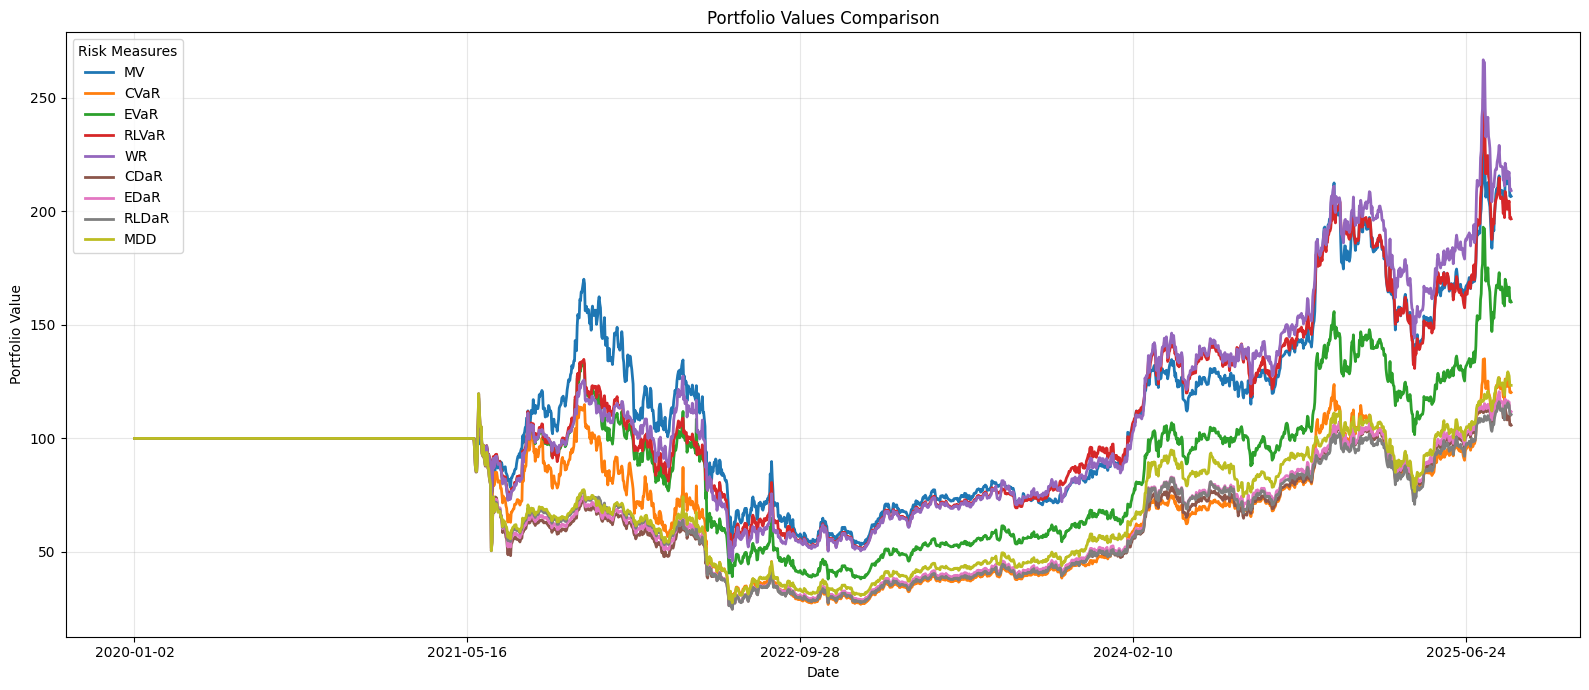


=== Performance Summary ===
MV      : +106.7% total return
CVaR    :  +20.3% total return
EVaR    :  +60.1% total return
RLVaR   :  +96.7% total return
WR      : +109.2% total return
CDaR    :   +5.8% total return
EDaR    :  +11.8% total return
RLDaR   :  +10.5% total return
MDD     :  +23.4% total return


In [37]:
# Plotting Portfolio Values
import matplotlib.pyplot as plt

# Check if portfolio strategies are available
if 'portfolio' in locals() and len(portfolio) > 0:
    fig, ax = plt.subplots(figsize=(16,7))
    
    values = pd.DataFrame([])
    available_strategies = list(portfolio.keys())
    
    print(f"Plotting portfolio values for strategies: {available_strategies}")
    
    for strategy in available_strategies:
        try:
            portfolio_value = portfolio[strategy].value()
            values = pd.concat([values, portfolio_value], axis=1)
        except Exception as e:
            print(f"Failed to get values for {strategy}: {e}")
            continue
    
    if not values.empty:
        values.columns = available_strategies
        values.plot(ax=ax, title='Portfolio Values Comparison', linewidth=2)
        ax.set_xlabel('Date')
        ax.set_ylabel('Portfolio Value')
        ax.legend(title='Risk Measures')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Print performance summary
        print("\n=== Performance Summary ===")
        final_values = values.iloc[-1]
        initial_values = values.iloc[0]
        total_returns = (final_values / initial_values - 1) * 100
        
        for strategy in available_strategies:
            print(f"{strategy:8s}: {total_returns[strategy]:+6.1f}% total return")
    else:
        print("No portfolio values available to plot.")
        
else:
    print("No portfolio strategies available. Run the backtesting cell first.")

In [38]:
# Portfolio Stats
if 'portfolio' in locals() and len(portfolio) > 0:
    stats = pd.DataFrame([])
    available_strategies = list(portfolio.keys())
    
    print(f"Calculating statistics for strategies: {available_strategies}")
    
    for strategy in available_strategies:
        try:
            strategy_stats = portfolio[strategy].stats()
            stats = pd.concat([stats, strategy_stats], axis=1)
        except Exception as e:
            print(f"Failed to get stats for {strategy}: {e}")
            continue
    
    if not stats.empty:
        stats.columns = available_strategies
        
        # Display the full statistics table
        print("\n=== Detailed Portfolio Statistics ===")
        display(stats)
        
        # Create a summary table with key metrics
        key_metrics = [
            'Total Return [%]',
            'Max Drawdown [%]', 
            'Sharpe Ratio',
            'Calmar Ratio'
        ]
        
        available_metrics = [metric for metric in key_metrics if metric in stats.index]
        
        if available_metrics:
            print(f"\n=== Key Metrics Summary ===")
            summary_stats = stats.loc[available_metrics]
            display(summary_stats.round(3))
            
            # Find best performing strategy
            if 'Total Return [%]' in stats.index:
                best_return = stats.loc['Total Return [%]'].idxmax()
                print(f"\nBest Total Return: {best_return} ({stats.loc['Total Return [%]', best_return]:.2f}%)")
            
            if 'Sharpe Ratio' in stats.index:
                best_sharpe = stats.loc['Sharpe Ratio'].idxmax()
                print(f"Best Sharpe Ratio: {best_sharpe} ({stats.loc['Sharpe Ratio', best_sharpe]:.3f})")
        
    else:
        print("No portfolio statistics available.")
        
else:
    print("No portfolio strategies available. Run the backtesting cell first.")

Calculating statistics for strategies: ['MV', 'CVaR', 'EVaR', 'RLVaR', 'WR', 'CDaR', 'EDaR', 'RLDaR', 'MDD']

=== Detailed Portfolio Statistics ===

=== Detailed Portfolio Statistics ===


,MV,CVaR,EVaR,RLVaR,WR,CDaR,EDaR,RLDaR,MDD
Start,2020-01-02,2020-01-02,2020-01-02,2020-01-02,2020-01-02,2020-01-02,2020-01-02,2020-01-02,2020-01-02
End,2025-08-31,2025-08-31,2025-08-31,2025-08-31,2025-08-31,2025-08-31,2025-08-31,2025-08-31,2025-08-31
Period,2069,2069,2069,2069,2069,2069,2069,2069,2069
Start Value,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
End Value,206.67003,120.265858,160.119394,196.726356,209.194866,105.835273,111.755886,110.493674,123.378564
Total Return [%],106.67003,20.265858,60.119394,96.726356,109.194866,5.835273,11.755886,10.493674,23.378564
Benchmark Return [%],2339.760407,2339.760407,2339.760407,2339.760407,2339.760407,2339.760407,2339.760407,2339.760407,2339.760407
Max Gross Exposure [%],100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
Total Fees Paid,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Max Drawdown [%],69.028327,76.627888,71.459913,63.797985,63.918702,78.901706,79.11452,79.316598,76.96561



=== Key Metrics Summary ===


,MV,CVaR,EVaR,RLVaR,WR,CDaR,EDaR,RLDaR,MDD
Total Return [%],106.67003,20.265858,60.119394,96.726356,109.194866,5.835273,11.755886,10.493674,23.378564
Max Drawdown [%],69.028327,76.627888,71.459913,63.797985,63.918702,78.901706,79.11452,79.316598,76.96561



Best Total Return: WR (109.19%)


Available strategies: ['MV', 'CVaR', 'EVaR', 'RLVaR', 'WR', 'CDaR', 'EDaR', 'RLDaR', 'MDD']
MV portfolio values shape: (2069,)
MV date range: 2020-01-02 to 2025-08-31
CVaR portfolio values shape: (2069,)
CVaR date range: 2020-01-02 to 2025-08-31
EVaR portfolio values shape: (2069,)
EVaR date range: 2020-01-02 to 2025-08-31
RLVaR portfolio values shape: (2069,)
RLVaR date range: 2020-01-02 to 2025-08-31
WR portfolio values shape: (2069,)
WR date range: 2020-01-02 to 2025-08-31
CDaR portfolio values shape: (2069,)
CDaR date range: 2020-01-02 to 2025-08-31
EDaR portfolio values shape: (2069,)
EDaR date range: 2020-01-02 to 2025-08-31
RLDaR portfolio values shape: (2069,)
RLDaR date range: 2020-01-02 to 2025-08-31
MDD portfolio values shape: (2069,)
MDD date range: 2020-01-02 to 2025-08-31


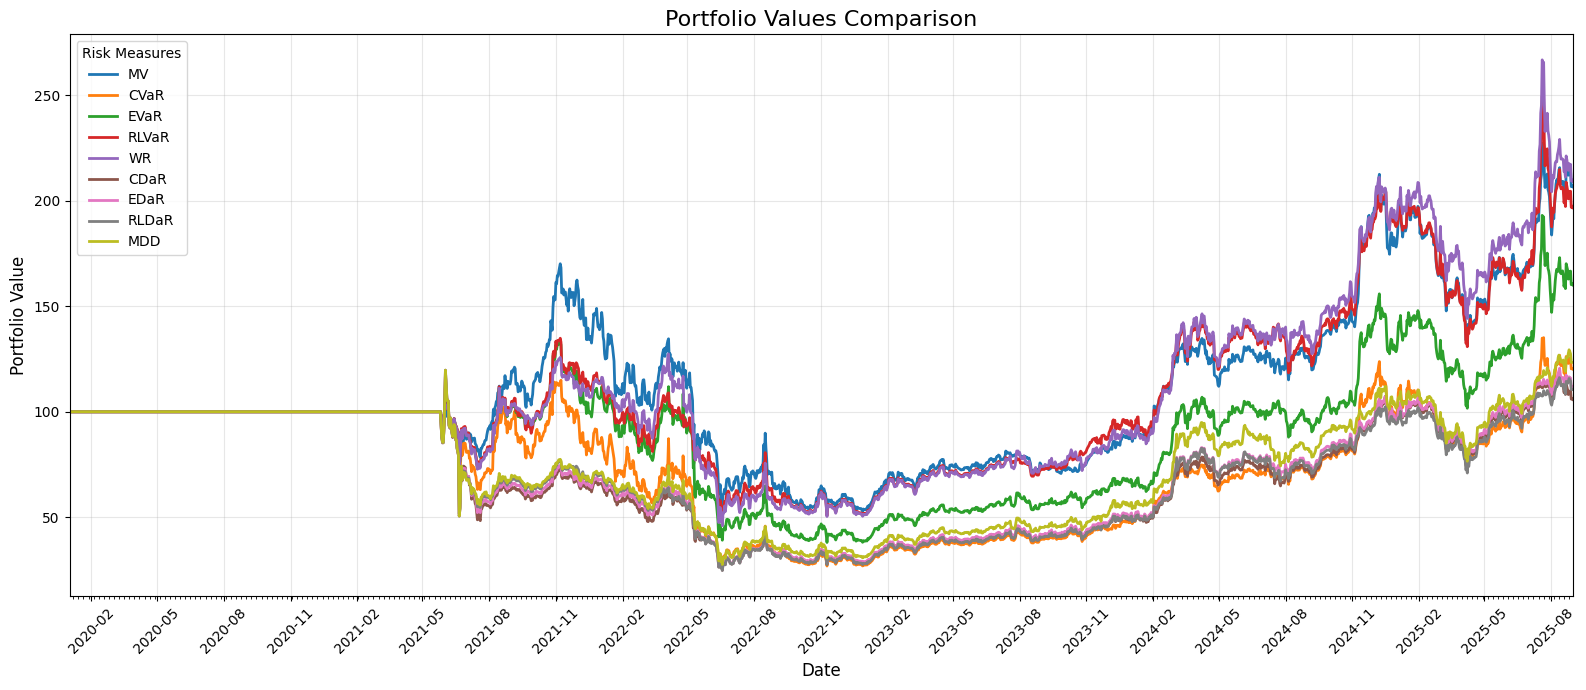

Date range: 2020-01-02 to 2025-08-31

=== Performance Comparison ===


,MV,CVaR,EVaR,RLVaR,WR,CDaR,EDaR,RLDaR,MDD
Final Value,$207,$120,$160,$197,$209,$106,$112,$110,$123
Total Return (%),106.67%,20.27%,60.12%,96.73%,109.19%,5.84%,11.76%,10.49%,23.38%
Max Drawdown (%),-69.03%,-76.63%,-71.46%,-63.80%,-63.92%,-78.90%,-79.11%,-79.32%,-76.97%



=== Sharpe Ratios ===


,Sharpe Ratio
MV,0.025303
CVaR,0.025086
RLDaR,0.024463
EVaR,0.023330
MDD,0.023310
EDaR,0.022886
RLVaR,0.021965
WR,0.020886
CDaR,0.017480


In [39]:
# Performance Visualization 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_portfolio_values(values_data):
    """Plot portfolio values comparison using matplotlib"""
    try:
        fig, ax = plt.subplots(figsize=(16, 7))
        
        # Convert to DataFrame for easy plotting
        values_df = pd.DataFrame(values_data)
        
        # Ensure the index is properly converted to datetime
        if not isinstance(values_df.index, pd.DatetimeIndex):
            values_df.index = pd.to_datetime(values_df.index)
        
        # Plot each strategy
        for strategy in values_df.columns:
            ax.plot(values_df.index, values_df[strategy], label=strategy, linewidth=2)
        
        ax.set_title('Portfolio Values Comparison', fontsize=16)
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Portfolio Value', fontsize=12)
        ax.legend(title='Risk Measures')
        ax.grid(True, alpha=0.3)
        
        # Format x-axis to show dates with 1-month intervals
        # Set date limits to the actual data range
        ax.set_xlim(values_df.index.min(), values_df.index.max())
        
        # Use appropriate date formatting based on the data range
        years_span = (values_df.index.max() - values_df.index.min()).days / 365.25
        
        if years_span > 3:
            # For longer periods, show every 3 months
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        else:
            # For shorter periods, show every month
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        
        ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
        
        # Rotate dates for better readability
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Print date range for verification
        print(f"Date range: {values_df.index.min().strftime('%Y-%m-%d')} to {values_df.index.max().strftime('%Y-%m-%d')}")
        
    except Exception as e:
        print(f"Failed to plot portfolio values: {e}")
        import traceback
        traceback.print_exc()

if 'portfolio' in locals() and len(portfolio) > 0:
    available_strategies = list(portfolio.keys())
    print(f"Available strategies: {available_strategies}")
    
    # Check if we have portfolio values data
    values_data = {}
    for strategy in available_strategies:
        try:
            portfolio_values = portfolio[strategy].value()
            print(f"{strategy} portfolio values shape: {portfolio_values.shape}")
            print(f"{strategy} date range: {portfolio_values.index.min()} to {portfolio_values.index.max()}")
            values_data[strategy] = portfolio_values
        except Exception as e:
            print(f"Could not get portfolio values for {strategy}: {e}")
            continue
    
    if values_data:
        # Create the performance comparison plot
        plot_portfolio_values(values_data)
        
        # Calculate and display some key performance metrics
        print("\n=== Performance Comparison ===")
        
        performance_summary = pd.DataFrame(index=['Final Value', 'Total Return (%)', 'Max Drawdown (%)'])
        
        for strategy, values in values_data.items():
            try:
                final_value = values.iloc[-1]
                initial_value = values.iloc[0] 
                total_return = ((final_value / initial_value) - 1) * 100
                
                # Calculate maximum drawdown
                peak = values.expanding().max()
                drawdown = ((values - peak) / peak) * 100
                max_drawdown = drawdown.min()
                
                performance_summary[strategy] = [
                    f"${final_value:,.0f}",
                    f"{total_return:.2f}%", 
                    f"{max_drawdown:.2f}%"
                ]
                
            except Exception as e:
                print(f"Error calculating metrics for {strategy}: {e}")
                performance_summary[strategy] = ["N/A", "N/A", "N/A"]
        
        if not performance_summary.empty:
            display(performance_summary)
            
        # Display Sharpe ratios if available (get the latest non-NaN value for each strategy)
        if 'sharpe' in locals() and sharpe:
            print("\n=== Sharpe Ratios ===")
            sharpe_summary = {}
            for strategy, sharpe_array in sharpe.items():
                try:
                    # Get the last non-NaN value from the array
                    valid_sharpe = sharpe_array[~np.isnan(sharpe_array)]
                    if len(valid_sharpe) > 0:
                        sharpe_summary[strategy] = valid_sharpe[-1]
                    else:
                        sharpe_summary[strategy] = 0.0
                except:
                    sharpe_summary[strategy] = 0.0
            
            if sharpe_summary:
                sharpe_df = pd.DataFrame.from_dict(sharpe_summary, orient='index', columns=['Sharpe Ratio'])
                display(sharpe_df.sort_values('Sharpe Ratio', ascending=False))
                
    else:
        print("No portfolio value data available for visualization.")
        
else:
    print("No portfolio data available. Please run the backtesting simulation first.")